# Applying Stereo Depth to Driving Scenario
This notebook will provide you with the general idea about how depth estimation can be done with the help of stereo camera setup.

## 1 - Importing Packages
Following snippet imports all the necessary packages to carry out the process. The `data_management` package contains pre-developed functions for importing data for the project.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import data_management

Now, we can load the pair of stereo images to work with. The following code will load the images and display them.

Text(0.5, 1.0, 'Right Image')

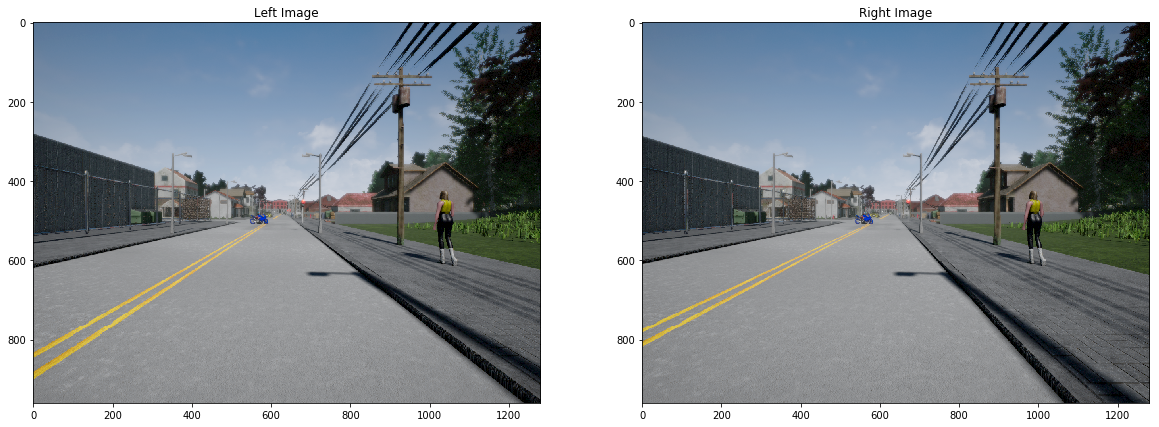

In [4]:
# Read the stereo-pair of images
left_image = data_management.read_left_image()
right_image = data_management.read_right_image()

# Use matplotlib to display the two images
_, image_cells = plt.subplots(1, 2, figsize = (20, 20))
image_cells[0].imshow(left_image)
image_cells[0].set_title("Left Image")
image_cells[1].imshow(right_image)
image_cells[1].set_title("Right Image")

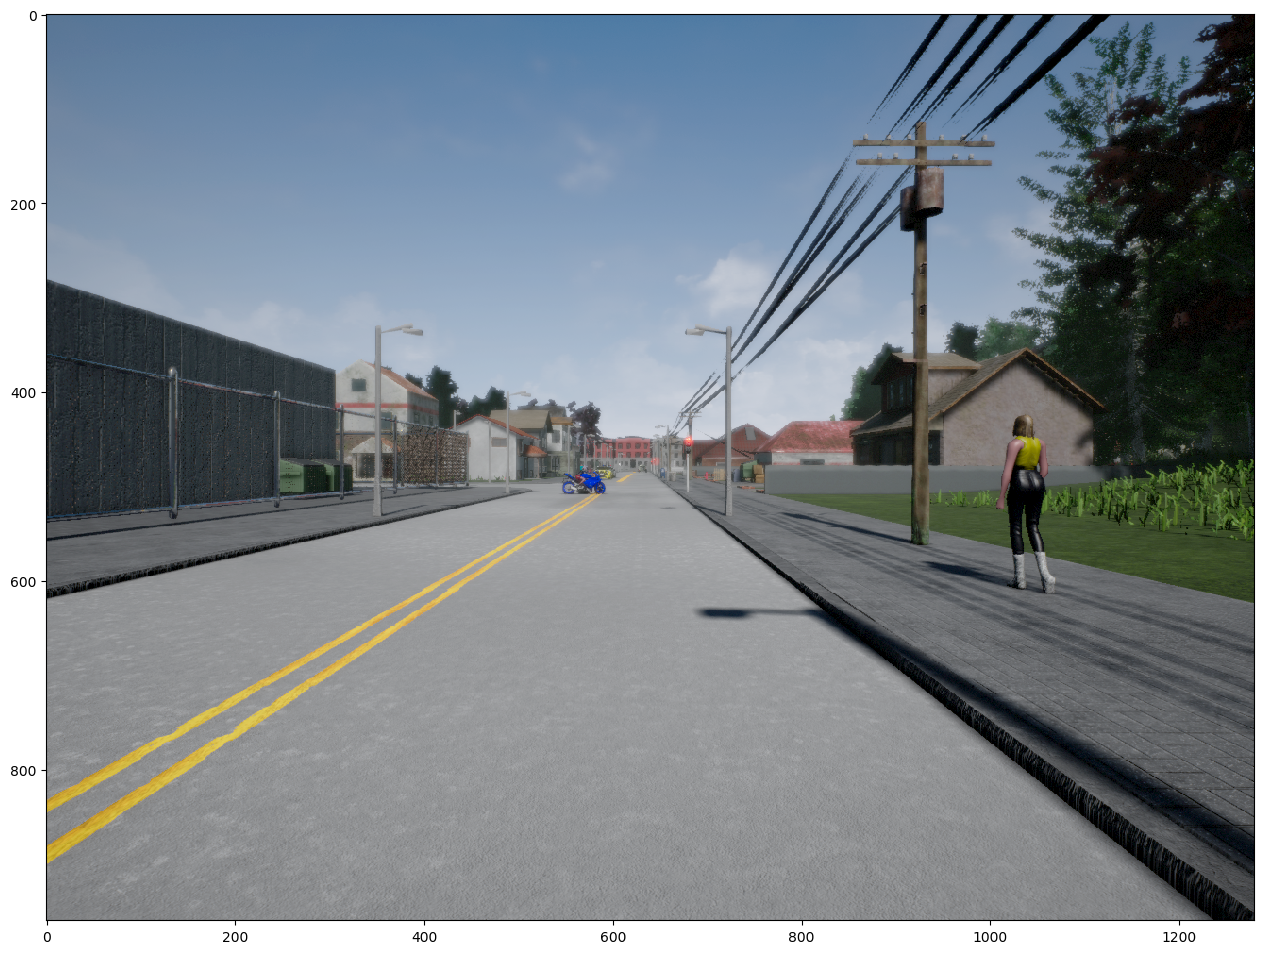

In [5]:
# Larger plot of left image
plt.figure(figsize = (16,12), dpi = 100)
plt.imshow(left_image)

Now, lets load their respective camera matrices. Following code loads and prints them.

In [8]:
# Read projection matrices
p_left, p_right = data_management.get_projection_matrices()

# Print these values
np.set_printoptions(suppress = True)
print("p_left \n", p_left)
print("\np_right \n", p_right)

p_left 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   552. ]
 [   0.     0.     1.     1.4]]

p_right 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   792. ]
 [   0.     0.     1.     1.4]]


## 2 - Depth Estimation
The Estimation process can be broken down into three main step as mentioned below:
1. Determin disparit between the two images.
2. Decompose the projection matrices into the camera intrinsic $K$, and extrinsics $R$ (Rotation), $t$ (Translation).
3. Estimate depth using information gathered in steps 1 and 2.

### 2.1 - Compute Disparity
The following `compute_disparity_map` function is expected to receive a stereo pair of images and return a disparity map from the perspective of left camera.

We are going to use [StereoSGBM](https://docs.opencv.org/3.4.3/d2/d85/classcv_1_1StereoSGBM.html) to compute disparity map.

**Note**: Make sure you are using grayscale images for the `matcher.compute` method.

In [9]:
def compute_disparity_map(left_image, right_image):
    num_disparities = 6 * 16
    block_size = 11
    
    min_disparity = 0
    window_size = 6
    
    left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
    
    # Creating Matcher object
    left_matcher = cv2.StereoSGBM_create(minDisparity = min_disparity, 
                                              numDisparities = num_disparities, 
                                              blockSize = block_size, 
                                              P1 = 8 * 3 * window_size ** 2, 
                                              P2 = 32 * 3 * window_size **2, 
                                              mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    
    # Compute left disparity map
    left_disparity = left_matcher.compute(left_image, right_image)
    left_disparity = left_disparity.astype(np.float32)/16
    
    return left_disparity

Now, to get an idea of how the parameters affect the resulting disparity map you can run the follwoing code to visualize it.

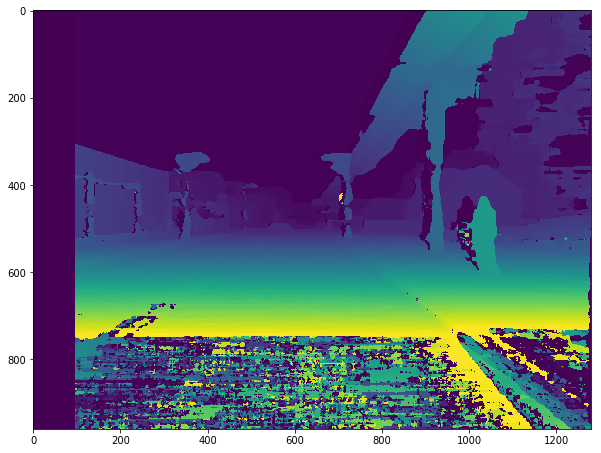

In [10]:
# Compute disparity map
left_disparity = compute_disparity_map(left_image, right_image)

# View left disparity map
plt.figure(figsize = (10,10))
plt.imshow(left_disparity)
plt.show()

### 2.2 - Projection Matrix Decomposition
The decomposition process can be explained as follows:
1. Represent P as a combination of intrinsic paramters $K$ and extrinsic rotation $R$ and translation $t$ as follows:
$$ $$
$$P = K[R|t]$$
$$ $$
2. Take the inverse of $KR$, which allows us to perform QR-decomposition to get $R^{-1}$ and $K^{-1}$:
$$ $$
$$(KR)^{-1} = R^{-1}K^{-1}$$
$$ $$
3. From here we could determine, $K$, $R$, and $t$.

We use OpenCV's cv2.[decomposeProjectionMatrix()](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html#gaaae5a7899faa1ffdf268cd9088940248) to perform all of the three steps mentioned above.

**Note**: After carrying out the matrix multiplication, the homogeneous component $w_c$ will, in general, not be equal to 1. Therefore, to map back into the real plane we must perform the homogeneous divide or perspective divide by dividing each component by $w_c$

In [11]:
def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t / t[3]
    return k, r, t

In the following code we decompose our left and right projection matrices and print all the matrices.

In [13]:
# Decompose projection matrices
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Display the matrices
print("k_left\n", k_left)
print("\nr_left\n", r_left)
print("\nt_left\n", t_left)
print("\nk_right\n",k_right)
print("\nr_right\n",r_right)
print("\nt_right\n",t_right)

k_left
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_left
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left
 [[-2.  ]
 [ 0.25]
 [-1.4 ]
 [ 1.  ]]

k_right
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_right
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right
 [[-2.  ]
 [-0.25]
 [-1.4 ]
 [ 1.  ]]


### 2.3 - Depth Map Generation
This process can be explained as follows:
1. Get the focal length $f$ from the $K$ matrix
2. Compute the baseline $b$ using corresponding values from the translation vector $t$
3. Compute depth map of the image: $$Z = \frac{f b}{x_L -x_R} = \frac{f b}{d}$$ In the above equation, $d$ is a disparity map which has already been calculated previously in the notebook.

In [14]:
def calc_depth_map(disp_left, k_left, t_left, t_right):
    
    # Get focal length from K matrix
    f = k_left[0,0]
    
    # Get the distance between the cameras from the t matrices (baseline)
    b = t_left[1] - t_right[1]
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left == 0] = 0.1
    disp_left[disp_left == 1] = 0.1
    
    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disp_left.shape, np.single)
    
    # Calculate the depth
    depth_map[:] = f * b / disp_left[:]
    
    return depth_map

Following code calculates the depth map from disparity map and displays for reference.

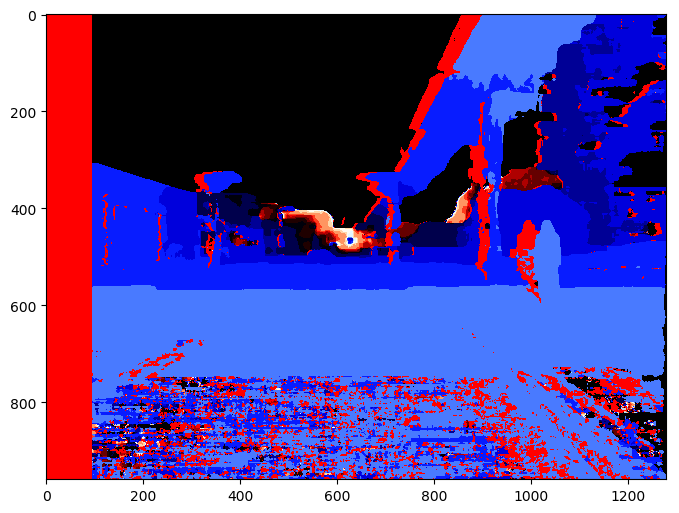

In [18]:
# Calculate depth map
depth_map_left = calc_depth_map(left_disparity, k_left, t_left, t_right)

# Display the depth map
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(depth_map_left, cmap='flag')
plt.show()

## 3 - Finding Collision Distance
While we may have a map of the depths of each pixel in the scene, our system does not yet know which of these pixels are safe (like the road) or a potential obstacle (like a motorcycle). To find these objects of interest an oject detector is used that has been trained to select a rectangular section containing object we are concerned about.

Run the following section of code to read the motorcycle image and display it.

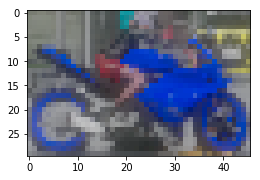

In [19]:
# Get the image of the obstacle
obstacle_image = data_management.get_obstacle_image()

# Show the obstacle image
plt.figure(figsize=(4, 4))
plt.imshow(obstacle_image)
plt.show()

Now, we would like to have the system automatically determine where this obstacle is in the scene. For this we will use cross correlation.

We will use OpenCV's cv2.[matchTemplate()](https://docs.opencv.org/3.4.3/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be) function to quickly and easily complete the cross correlation of the obstacle template. From this heatmap we can use the cv2.[minMaxLoc()](https://docs.opencv.org/3.4.3/d2/de8/group__core__array.html#ga8873b86a29c5af51cafdcee82f8150a7) function to extract the position of the obstacle.


In [24]:
def locate_obstacle_in_image(image, obstacle_image):
    
    # Template matching from OpenCV
    cross_corr_map = cv2.matchTemplate(image, obstacle_image, method = cv2.TM_CCOEFF)
    
    # Locate the position of the obstacle
    _, _, _, obstacle_location = cv2.minMaxLoc(cross_corr_map)
    
    return cross_corr_map, obstacle_location


The following code will calculate the cross correlation and find obstacle location coordinates, and then display the resulting cross correlation heatmap and obstacle location coordinates

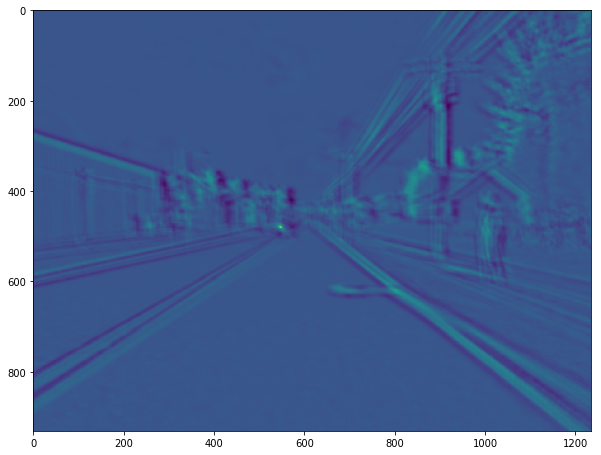

obstacle_location 
 (547, 479)


In [25]:
# Gather the cross correlation map and the obstacle location in the image
cross_corr_map, obstacle_location = locate_obstacle_in_image(left_image, obstacle_image)

# Display the cross correlation heatmap 
plt.figure(figsize=(10, 10))
plt.imshow(cross_corr_map)
plt.show()

# Print the obstacle location
print("obstacle_location \n", obstacle_location)

Great! Now, all that's left is to crop the section of depth map that corresponds to the obstacle and find the nearest point in that crop.

In [26]:
def calculate_nearest_point(depth_map, obstacle_location, obstacle_img):
    
    ### START CODE HERE ###
    
    # Gather the relative parameters of the obstacle box
    obstacle_width = obstacle_img.shape[0]
    print(obstacle_width)
    obstacle_height = obstacle_img.shape[1]
    print(obstacle_height)
    obstacle_min_x_pos = obstacle_location[1]
    obstacle_max_x_pos = obstacle_location[1] + obstacle_width
    obstacle_min_y_pos = obstacle_location[0]
    obstacle_max_y_pos = obstacle_location[0] + obstacle_height

    # Get the depth of the pixels within the bounds of the obstacle image, find the closest point in this rectangle
    obstacle_depth = depth_map_left[obstacle_min_x_pos:obstacle_max_x_pos, obstacle_min_y_pos:obstacle_max_y_pos]
    closest_point_depth = obstacle_depth.min()

    ### END CODE HERE ###
    
    # Create the obstacle bounding box 
    obstacle_bbox = patches.Rectangle((obstacle_min_y_pos, obstacle_min_x_pos), obstacle_height, obstacle_width, 
                                 linewidth=1, edgecolor='r', facecolor='none')
    
    return closest_point_depth, obstacle_bbox

Now run the following code to visualize the bounding box and the deoth of the nearest point.

30
46


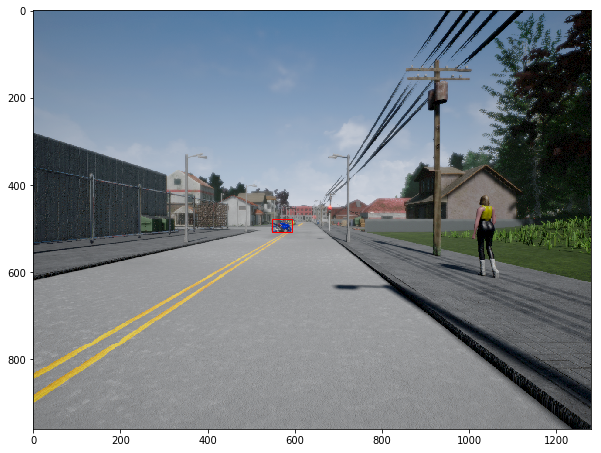

closest_point_depth -320.000


In [27]:
# Use the developed nearest point function to get the closest point depth and obstacle bounding box
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)

# Display the image with the bounding box displayed
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(left_image)
ax.add_patch(obstacle_bbox)
plt.show()

# Print the depth of the nearest point
print("closest_point_depth {0:0.3f}".format(closest_point_depth))